## Description
In this notebook, I look for peaks in the average spectra which support two different spatial distributions on their two tails. 

## Data & modules

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
import numpy.random as rd
from venn import venn
from additional_functions import profile_ion_image, centroided_ion_image, plot_summary_spectrum

In [3]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [4]:
names = ['cerebellum', 'bladder']
raw_images = {'cerebellum': cerebellum_profile_image, 'bladder': bladder_profile_image}

In [5]:
average_spectra = {}
for i, n in enumerate(names):
    sp = open(n + '_centroided_average_spectrum.tsv')
    next(sp) # skipping the header
    sp = [l.strip().split('\t') for l in sp]
    sp = [(float(mz), float(intsy)) for mz, intsy in sp]
    sp = Spectrum(confs=sp)
    sp.normalize()
    average_spectra[n] = sp

In [6]:
profile_average_spectra = {}
profile_summary_spectra = {}
for i, n in enumerate(names):
    sp = open(n + '_profile_summary_spectrum.tsv')
    next(sp) # skipping the header
    sp = [l.strip().split('\t') for l in sp]
    mz = [float(l[0]) for l in sp]
    av_confs = [(float(l[0]), float(l[1])) for l in sp]
    summary = np.array([list(map(float, l[1:])) for l in sp])
    sp = Spectrum(confs=av_confs)
    sp.normalize()
    profile_average_spectra[n] = sp
    profile_summary_spectra[n] = (mz, summary)

In [7]:
?plot_summary_spectrum

<IPython.core.display.Javascript object>


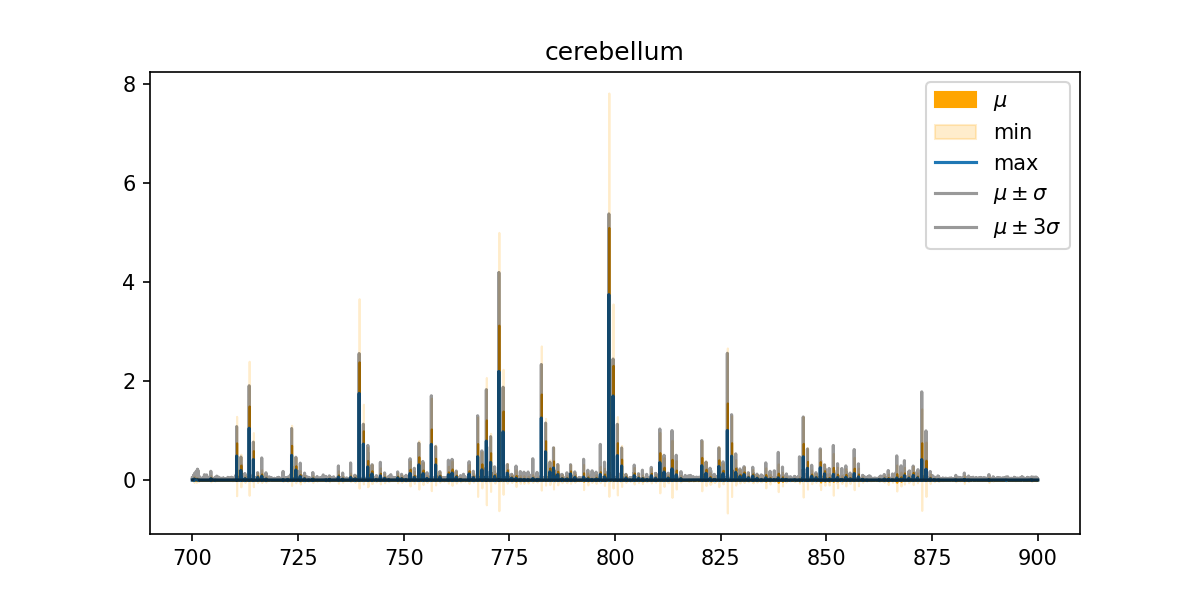

<IPython.core.display.Javascript object>


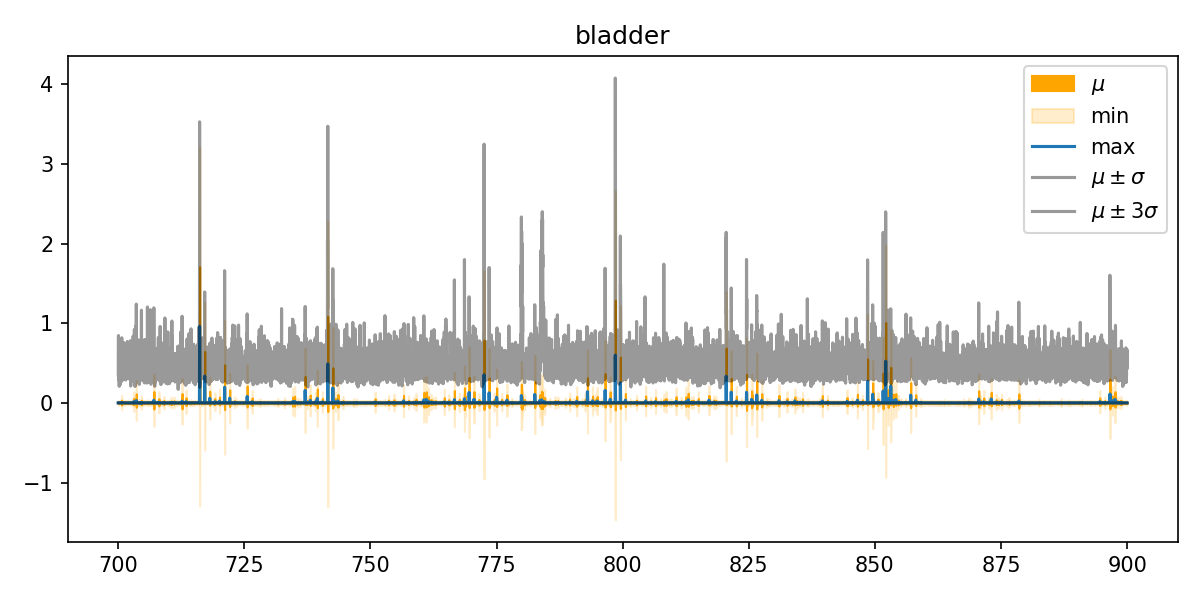

In [8]:
for i, n in enumerate(names):
    # profile_average_spectra[n].plot(profile=True)
    plot_summary_spectrum(profile_summary_spectra[n][0], profile_summary_spectra[n][1], plot_title=n)
plt.tight_layout()

In [9]:
peak_width_functions = {}
peak_width_functions['bladder'] = lambda mz: (741.563-741.50)*(852.1387-mz)/(852.1387-741.53) + (852.1880-852.0966)*(mz-741.53)/(852.1387-741.53)
peak_width_functions['cerebellum'] = lambda mz: (739.48990 - 739.44971)*(872.5582 - mz)/(872.5582-739.46871)  +   (872.5807 -872.5334)*(mz-739.46871)/(872.5582-739.46871)

## Detecting hidden lipids

In [19]:
# tail_correlations = {n: [] for n in names}
# for n in names:
#     top_peaks = sorted(average_spectra[n].confs, key=lambda x: x[1], reverse=True) 
#     for p in top_peaks[:100]:
#         mz = p[0]
#         w = peak_width_functions[n](mz)
#         m1 = mz+w/3
#         m2 = mz-w/3
#         im1 = profile_ion_image(raw_images[n], m1)
#         im2 = profile_ion_image(raw_images[n], m2)
#         im1 -= np.mean(im1)
#         im1 /= np.std(im1)
#         im2 -= np.mean(im2)
#         im2 /= np.std(im2)
#         cor = np.mean(im1*im2)
#         tail_correlations[n].append((p, cor))
#     tail_correlations[n] = sorted(tail_correlations[n], key=lambda x: x[1])[:20]

In [20]:
# n='bladder'
# top_peaks = sorted(average_spectra[n].confs, key=lambda x: x[1], reverse=True) 
# tail_correlations[n] = []
# for p in top_peaks[:100]:
#     mz = p[0]
#     w = peak_width_functions[n](mz)
#     m1 = mz+w/5
#     m2 = mz-w/5
#     im1 = profile_ion_image(raw_images[n], m1)
#     im2 = profile_ion_image(raw_images[n], m2)
#     im1 -= np.mean(im1)
#     im1 /= np.std(im1)
#     im2 -= np.mean(im2)
#     im2 /= np.std(im2)
#     cor = np.mean(im1*im2)
#     tail_correlations[n].append((p, cor))
# tail_correlations[n] = sorted(tail_correlations[n], key=lambda x: x[1])

In [21]:
# [x for x in tail_correlations['bladder'] if x[0][1] > 0.001]

**Checking peaks hidden within other peaks:**

Good for cerebellum, not good for bladder.

In [22]:
test_image = 'bladder'
test_peak =  790.920 # tail_correlations['bladder'][1][0][0]
test_pair = (test_peak - peak_width_functions[test_image](test_peak)/5, test_peak + peak_width_functions[test_image](test_peak)/5)

<IPython.core.display.Javascript object>


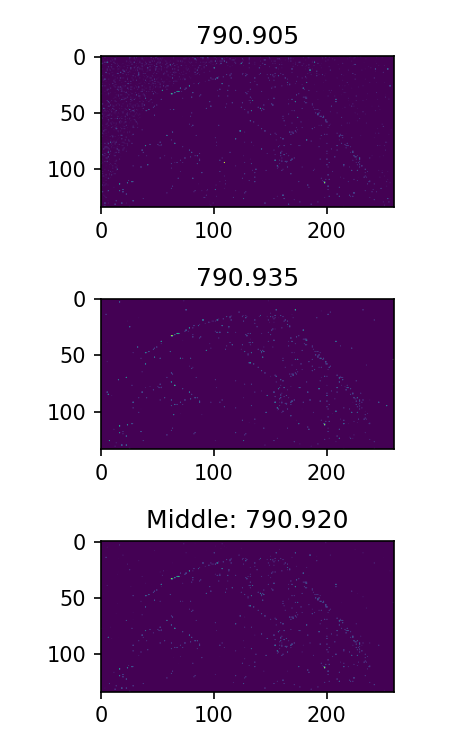

0.5635075414121481


In [23]:
image1 = profile_ion_image(raw_images[test_image], test_pair[0])
image2 = profile_ion_image(raw_images[test_image], test_pair[1])
image_middle = profile_ion_image(raw_images[test_image], np.mean(test_pair))
plt.figure(figsize=(3,5))
plt.subplot(311)
plt.imshow(image1)
plt.title('%.3f' % test_pair[0])
plt.subplot(312)
plt.imshow(image2)
plt.title('%.3f' % test_pair[1])
plt.subplot(313)
plt.imshow(image_middle)
plt.title('Middle: %.3f' % np.mean(test_pair))
print(np.mean((image1-np.mean(image1))*(image2-np.mean(image2))/(np.std(image1)*np.std(image2))))
plt.tight_layout()

In [18]:
test_image = 'bladder'
# test_pair = (779.91, 779.989)  # spurious
# test_pair = (849.557, 849.624)  # good but visible separation of peaks
test_pair = (794.9831, 795.0278) # ok but background

test_pair = (810.54, 810.6)  # good but visible separation of peaks
# test_pair = (790.8746, 790.9174)  # moderate
# test_pair = (796.5255, 796.5839) # good
# test_pair = (770.507, 770.565) # visible separation
test_pair = (826.570, 826.6274) 
test_image = 'cerebellum'
# test_pair = (784.5682, 784.5863)   # nice effect but two peaks recognizable
# test_pair = (783.56, 783.58)  # no effect
# test_pair = (725.495, 725.510)  # good
# test_pair = (830.51, 830.532)   # good
# test_pair = (737.439, 737.466)  # weak
# test_pair = (766.474, 766.494)  # weak
# test_pair = (797.512, 797.53)  # nice
test_pair=(814.5312, 814.5626)
test_pair=(782.567, 783.56)

<IPython.core.display.Javascript object>


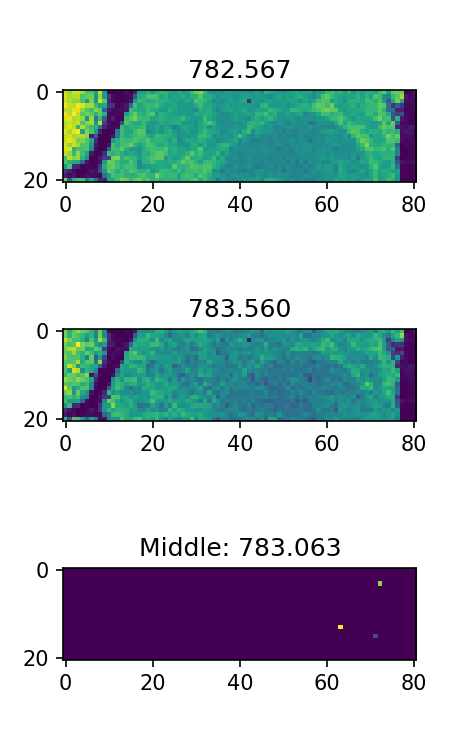

0.9605785411421529


In [19]:
image1 = profile_ion_image(raw_images[test_image], test_pair[0])
image2 = profile_ion_image(raw_images[test_image], test_pair[1])
image_middle = profile_ion_image(raw_images[test_image], np.mean(test_pair))
plt.figure(figsize=(3,5))
plt.subplot(311)
plt.imshow(image1)
plt.title('%.3f' % test_pair[0])
plt.subplot(312)
plt.imshow(image2)
plt.title('%.3f' % test_pair[1])
plt.subplot(313)
plt.imshow(image_middle)
plt.title('Middle: %.3f' % np.mean(test_pair))
print(np.mean((image1-np.mean(image1))*(image2-np.mean(image2))/(np.std(image1)*np.std(image2))))
plt.tight_layout()

In [26]:
# (peak in the centroided average, (tail points in profile))
hidden_in_overlap = {'cerebellum': [(725.5109, (725.495, 725.510)), 
                               (830.5321, (830.51, 830.532)), 
                               (797.5189, (797.512, 797.53))],  
                'bladder': [(796.5255, 796.5839), 
                           (790.8746, 790.9174),
                           (826.570, 826.6274) ]}

**Checking peaks which are too low on the average spectrum, but have a decent SD:**
Works better for bladder

In [27]:
test_image = 'bladder'
test_peak =  863.687 # tail_correlations['bladder'][1][0][0]


<IPython.core.display.Javascript object>


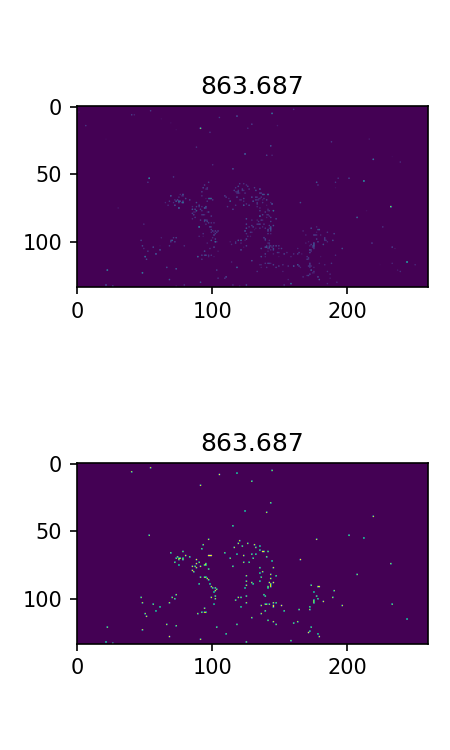

In [28]:
img = profile_ion_image(raw_images[test_image], test_peak)
plt.figure(figsize=(3,5))
plt.subplot(211)
plt.imshow(img)
plt.title('%.3f' %test_peak)
plt.subplot(212)
plt.imshow(img>0.1)
plt.title('%.3f' % test_peak)
plt.tight_layout()

In [29]:
# (peak in the centroided average, (tail points in profile))
hidden_in_small_regions = {'cerebellum': [],  
                'bladder': [768.501, 809.162, 817.4700]}

## Creating figures

### Cerebellum

Hidden in overlaps

In [58]:
test_image = 'cerebellum'

In [59]:
hidden_in_overlap['cerebellum']

[(725.5109, (725.495, 725.51)),
 (830.5321, (830.51, 830.532)),
 (797.5189, (797.512, 797.53))]

In [60]:
test_pair = hidden_in_overlap['cerebellum'][0][1]

In [42]:
mz = profile_summary_spectra['cerebellum'][0]
av = profile_summary_spectra['cerebellum'][1][:,0]
sd = profile_summary_spectra['cerebellum'][1][:,1]
mx = profile_summary_spectra['cerebellum'][1][:,3]

<IPython.core.display.Javascript object>


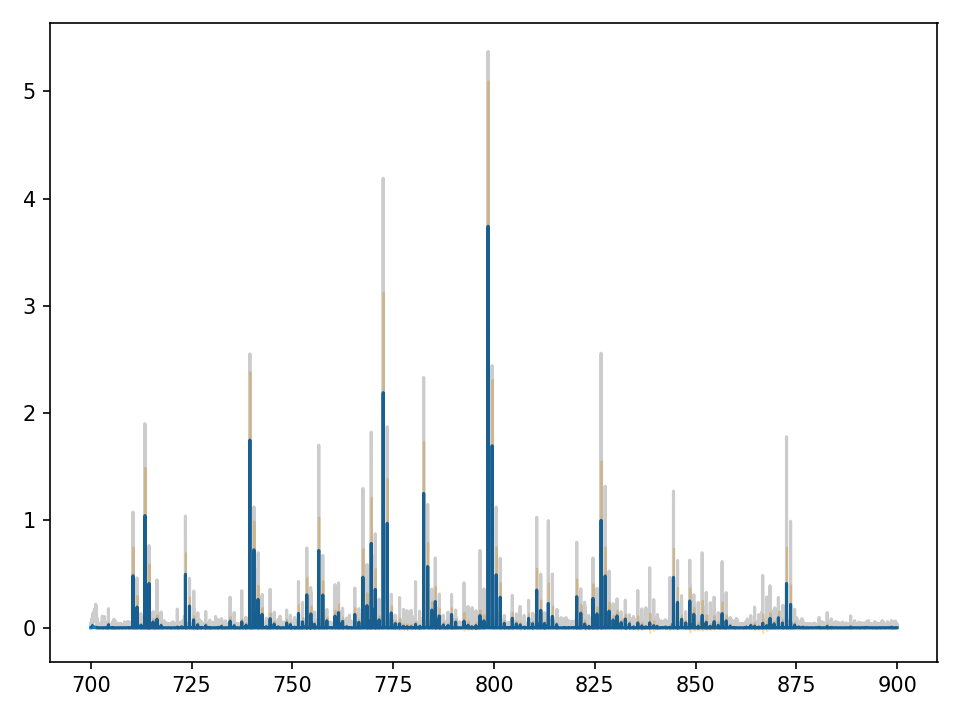

In [64]:
plt.figure()
plt.plot(mz, av)
plt.fill_between(mz, av-sd, av+sd, alpha=0.3, color='orange')
plt.plot(mz, mx, 'k', alpha=0.2)
#plt.legend(['Average', 'Av. $\pm\ \sigma$', 'Skyline'])
plt.tight_layout()

<IPython.core.display.Javascript object>


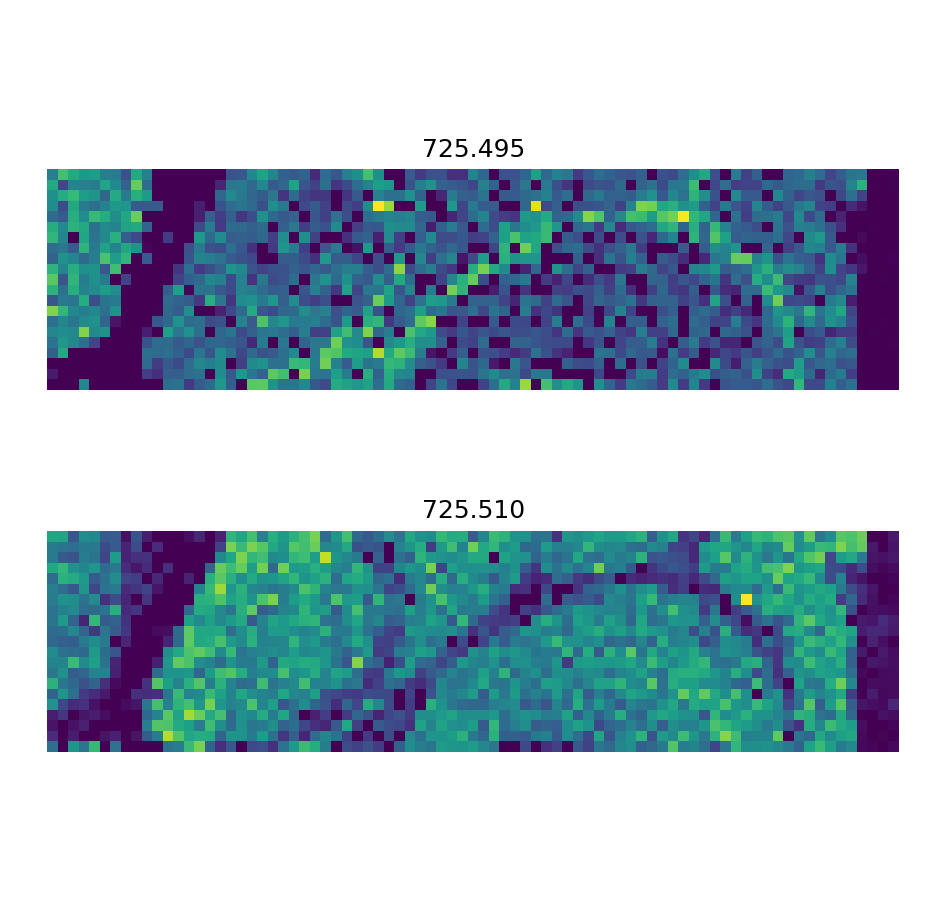

In [62]:
image1 = profile_ion_image(raw_images[test_image], test_pair[0])
image2 = profile_ion_image(raw_images[test_image], test_pair[1])
image_middle = profile_ion_image(raw_images[test_image], np.mean(test_pair))
plt.figure(figsize=(3,5))
plt.subplot(211)
plt.imshow(image1)
plt.title('%.3f' % test_pair[0])
plt.axis('off')
plt.subplot(212)
plt.imshow(image2)
plt.title('%.3f' % test_pair[1])
plt.axis('off')
plt.tight_layout()